# EDA & Strategic Insights
**Goal:** Transform raw data into actionable business recommendations.

## Key Business Questions (Hypotheses)

### 1. Revenue Dynamics
* **Question:** How does **Average Order Value (AOV)** differ by country?
* **Hypothesis:** High revenue in top countries (e.g., Germany) might be driven by *larger basket sizes*, not just more customers. Are they buying "Premium" or just buying "More"?

### 2. Customer Segmentation (Behavior)
* **Question:** What is the distribution of **VIP vs. Standard** customers across regions?
* **Hypothesis:** Some countries may have a higher concentration of "One-time buyers" (Churn risk), while others foster "Loyalists". We need to visualize the **RFM breakdown**.

### 3. Operational Risk & Efficiency
* **Question:** Are customers **splitting orders** to avoid shipping fees?
* **Hypothesis:** If we see multiple orders from the same user on the same day, we are losing money on logistics.
* **Metric:** Count of "Same-Day Duplicate Orders" by Country.

### Data Limitations & Future Recommendations
To unlock deeper insights (ROI, Product Trends), I recommend collecting the following data points in the next iteration:

| Missing Data Point | Why it is critical? | Potential Insight |
| :--- | :--- | :--- |
| **Product Category** | Currently, we analyze generic "Orders". | Identifying high-margin categories (e.g., Electronics vs. Accessories) to optimize inventory. |
| **Cost of Goods Sold (COGS)** | We only see Revenue, not Profit. | Calculating **ROI** per country. Germany might bring high revenue but have low margins due to shipping costs. |
| **Customer Acquisition Source** | We don't know where users came from. | Measuring Marketing ROI (e.g., Instagram vs. Google Ads) to lower Customer Acquisition Cost (CAC). |

In [9]:
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

sns.set_theme(style="whitegrid")

conn = sqlite3.connect("../data/sales.db")


query = '''
    WITH CustMetrics AS (
        SELECT
            c.customer_id,
            c.country,
            o.order_date,
            --1. RECENCY:
            CAST(julianday('now') - julianday(MAX (o.order_date)) AS INTEGER) as order_recency,
            --2. MONETARY:
            SUM (o.order_amount) AS total_spent,
            --3. FREQUENCY:
            COUNT (o.order_id) AS order_count
        FROM orders o 
        JOIN customers c ON o.customer_id = c.customer_id
        GROUP BY c.customer_id
        ),
        RFM_score AS(
            SELECT *,
            NTILE(5) OVER (ORDER BY order_recency DESC) AS r_score,
            NTILE(5) OVER (ORDER BY order_count ASC) AS f_score,
            NTILE(5) OVER (ORDER BY total_spent ASC) AS m_score
            FROM CustMetrics
            )
    SELECT *,
        CASE
            WHEN r_score=5 AND m_score=5 AND f_score = 5 THEN 'Champion' 
            WHEN r_score >=4 AND m_score =5 AND f_score >=4 THEN 'Loyal'
            WHEN r_score=5 AND f_score = 1 THEN 'New Customer'
            WHEN r_score>=1 AND m_score >=2 AND f_score >=2 THEN 'At Risk'
            WHEN r_score>=1 AND m_score =5 AND f_score =5 THEN "Can't Lose"
            ELSE 'Standard'
        END AS customer_segment
    FROM  RFM_score
    '''
df_seg = pd.read_sql(query,conn)
conn.close()

print(df_seg['customer_segment'].value_counts())
print("-" * 30)
print(df_seg.head())



customer_segment
At Risk         334
Standard        110
Loyal            20
Champion         18
New Customer      8
Name: count, dtype: int64
------------------------------
   customer_id  country  order_date  order_recency  total_spent  order_count  \
0         1134       UK  2024-01-25            741       727.94            2   
1         1127       UK  2024-02-15            720       619.46            2   
2         1495  Germany  2024-02-23            712      1798.13            6   
3         1445   France  2024-02-27            708       363.82            1   
4         1341       UK  2024-03-01            705       536.10            2   

   r_score  f_score  m_score customer_segment  
0        1        2        2          At Risk  
1        1        1        2         Standard  
2        1        5        5          At Risk  
3        1        1        1         Standard  
4        1        1        2         Standard  


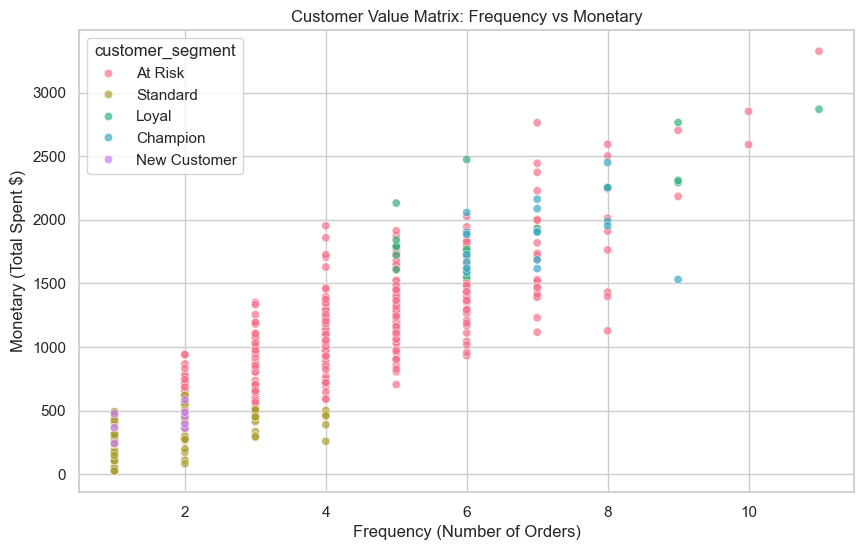

In [10]:
#Custome Value Matix
plt.figure(figsize = (10,6))
sns.scatterplot(data = df_seg, x = "order_count", y = "total_spent", hue = "customer_segment", alpha= 0.7, palette= "husl")
plt.title("Customer Value Matrix: Frequency vs Monetary")
plt.xlabel("Frequency (Number of Orders)")
plt.ylabel("Monetary (Total Spent $)")
plt.show()

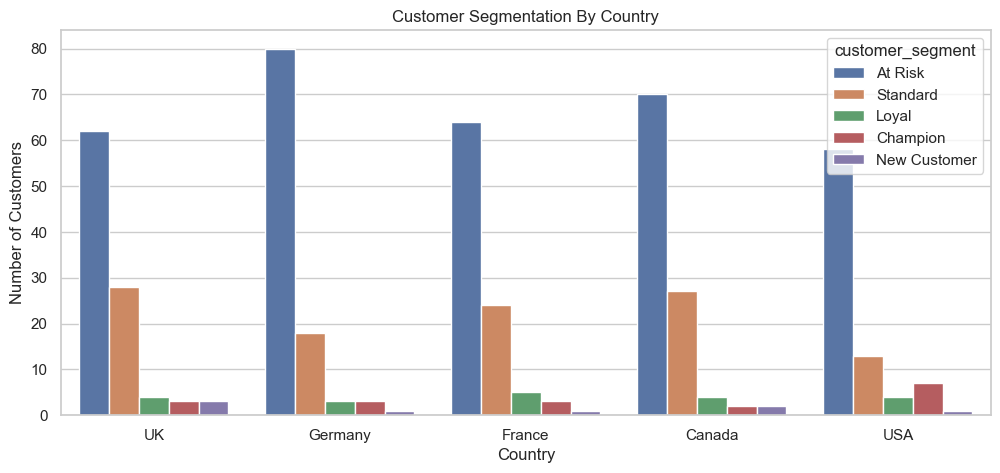

In [11]:
#Customer Segmentation By Country
plt.figure(figsize=(12,5))
sns.countplot(data = df_seg,  x = "country", hue = "customer_segment")
plt.title("Customer Segmentation By Country")
plt.xlabel("Country")
plt.ylabel("Number of Customers")
plt.show()

   country     aov
0   Canada  267.29
1   France  263.07
2  Germany  263.52
3       UK  254.95
4      USA  263.11


C:\Users\user\AppData\Local\Temp\ipykernel_40476\3765700534.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df1, x = "country", y = "aov", palette="mako", legend=False)


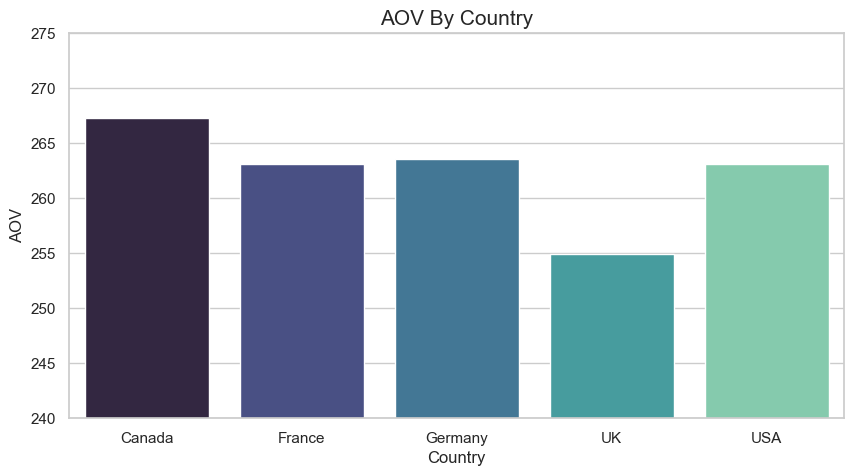

In [12]:
#AOV By Country
conn = sqlite3.connect("../data/sales.db")

query = '''
    WITH temp_table AS (
        SELECT 
            c.country AS country,
            o.order_id AS order_id,
            SUM(o.order_amount) AS total_sales

        FROM orders o
        JOIN customers c ON  o.customer_id = c.customer_id 
        GROUP BY country, o.order_id
        )
    SELECT 
        country,
        AVG (total_sales) AS aov
    FROM temp_table
    GROUP BY country
    '''
      
df1 = pd.read_sql(query,conn)
df1['aov'] = df1['aov'].round(2)
conn.close()
print (df1)

plt.figure(figsize=(10,5))
sns.barplot(data = df1, x = "country", y = "aov", palette="mako", legend=False)
plt.title("AOV By Country", fontsize = 15)
plt.xlabel("Country")
plt.ylabel("AOV")
plt.ylim(240, 275)
plt.show()

     month  total_revenue  country
0  2024-01         1006.0   Canada
1  2024-01         1483.6   France
2  2024-01         2007.2  Germany
3  2024-01         3722.3       UK
4  2024-01         1536.5      USA


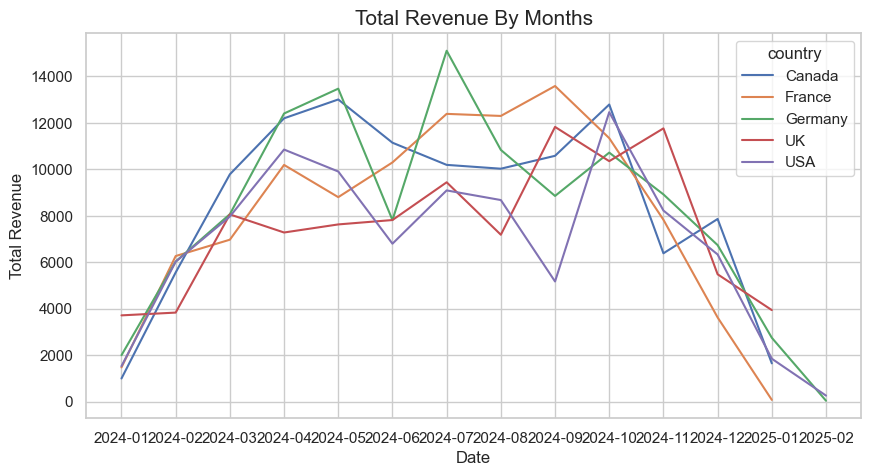

In [13]:

#Total Revenue By Months
conn = sqlite3.connect("../data/sales.db")

query = """
    SELECT
        strftime("%Y-%m", o.order_date) AS month,
        SUM (o.order_amount) AS total_revenue,
        c.country AS country
    From orders o 
    JOIN customers c ON c.customer_id = o.customer_id
    GROUP BY month, country
    ORDER BY month
    """
df_date = pd.read_sql(query, conn)
df_date ["total_revenue"] = df_date["total_revenue"].round(1)
conn.close()

print(df_date.head())

plt.figure(figsize=(10,5))
sns.lineplot(data = df_date, x = "month", y = "total_revenue", hue="country")
plt.title("Total Revenue By Months", fontsize = 15)
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.show()


